# CGANs - Conditional Generative Adversarial Nets

Introduction to Conditional Generative Adversarial Nets or CGANs.

This notebook is organized follows:

1. **Background**
* **Definition**
* **Training CGANs with MNIST dataset, Keras and TensorFlow**


## 1. Background

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The value function $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$


## 2. Definition

Generative adversarial nets can be extended to a **conditional model** if both the generator and discriminator are conditioned on some extra information $y$. 

* $y$ could be any kind of auxiliary information, such as class labels or data from other modalities. 

We can perform the conditioning by feeding $y$ into the both the discriminator and generator as additional input layer.

### Generator

The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation, and the adversarial training framework allows for considerable flexibility in how this hidden representation is composed.

### Discriminator

$x$ and $y$ are presented as inputs and to a discriminative function.

### Value function

$$ \underset{G}{min} \: \underset{D}{max} \; V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x|y)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z|y)))]$$

### Structure

![cgan](../../img/cgan.png)

## 3. Training CGANs with MNIST dataset, Keras and TensorFlow

CGANs implementation using fully connected and embedding layers and the [Keras](https://keras.io/) library.

### 1. Load data

#### Load libraries

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


---
#### Embedding layer background

[[[-0.04053744 -0.04949726]
  [ 0.01693013  0.01502175]
  [-0.00011484 -0.01029192]
  [-0.01990038  0.00251212]
  [ 0.04035911  0.01146444]
  [ 0.00912812 -0.00448591]
  [ 0.04693599 -0.03178742]
  [-0.00087533 -0.02172179]
  [ 0.0182437   0.02553446]
  [ 0.01668892  0.02129785]]]


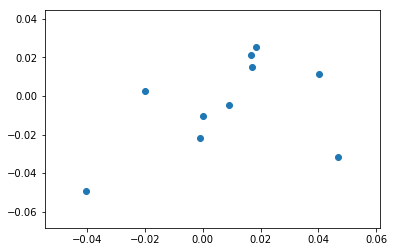

In [3]:
model = Sequential()
model.add(Embedding(10, 2))
# the model will take as input an integer matrix of size (batch, input_length).
# the largest integer (i.e. word index) in the input should be no larger than 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch dimension.

# input_array = np.random.randint(10, size=(1, 10))
input_array = np.arange(0, 10).reshape(1, -1)
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array)
# print(output_array.shape)
plt.scatter(output_array[0, :, 0], output_array[0, :, 1])

---
#### Getting the data

In [4]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#### Explore visual data

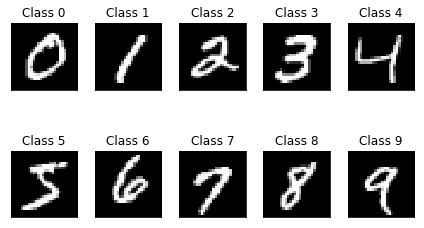

In [5]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [6]:
print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)

# reshaping the inputs
X_train = X_train.reshape(60000, 28*28)
# normalizing the inputs (-1, 1)
X_train = (X_train.astype('float32') / 255 - 0.5) * 2

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
y_train.shape (60000,)
X_train reshape: (60000, 784)


### 2. Define model

#### Generator

Our generator is a simple fully connected neural network with three hidden layer, ReLU activation and Batch Normalization.

In [ ]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# Input layer and hidden layer 1
generator.add(Dense(128, input_shape=(latent_dim,),
                    kernel_initializer=init))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Hidden layer 2
generator.add(Dense(256))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

# Hidden layer 3
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

# Output layer 
generator.add(Dense(img_dim, activation='tanh'))

#### Generator model visualization

In [7]:
# prints a summary representation of your model
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
__________

#### Conditional G model
The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation.

In [8]:
# Embedding condition in input layer
num_classes = 10

# Create label embeddings
label = Input(shape=(1,), dtype='int32')
label_embedding = Embedding(num_classes, latent_dim)(label)
label_embedding = Flatten()(label_embedding)

# latent space
z = Input(shape=(latent_dim,))

# Merge inputs (z x label)
input_generator = multiply([z, label_embedding])

# Output image
img = generator(input_generator)

# Generator with condition input
generator = Model([z, label], img)

#### Conditional model visualization

In [10]:
# prints a summary representation of your model
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       1000        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 100)          0           embedding_2[0][0]                
__________________________________________________________________________________________________
multiply_1

#### Discriminator

Our discriminator is a simple fully connected neural network with three hidden layer and ReLU activation.

In [11]:
# Discriminator network
discriminator = Sequential()

# Input layer and hidden layer 1
discriminator.add(Dense(128, input_shape=(img_dim,),
                        kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Hidden layer 2
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))

# Hidden layer 3
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(0.2))

# Output layer
discriminator.add(Dense(1, activation='sigmoid'))

#### Discriminator model visualization

In [12]:
# prints a summary representation of your model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total para

#### Conditional D model

$x$ and $y$ are presented as inputs

In [ ]:
# Embedding condition in input layer

# Create label embeddings
label_d = Input(shape=(1,), dtype='int32')
label_embedding_d = Embedding(num_classes, img_dim)(label_d)
label_embedding_d = Flatten()(label_embedding_d)

# imagem dimension 28x28
img_d = Input(shape=(img_dim,))

# Merge inputs (img x label)
input_discriminator = multiply([img_d, label_embedding_d])

# Output image
validity = discriminator(input_discriminator)

# Discriminator with condition input
discriminator = Model([img_d, label_d], validity)

#### Conditional model visualization

In [13]:
# prints a summary representation of your model
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 784)       7840        input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           embedding_3[0][0]                
__________________________________________________________________________________________________
multiply_2

### 3. Compile model

#### Compile discriminator

In [15]:
# Optimizer
opt = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(opt, loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

#### Combined network

In [16]:
discriminator.trainable = False

validity = discriminator([generator([z, label]), label])

d_g = Model([z, label], validity)

d_g.compile(opt, loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [17]:
# prints a summary representation of your model
d_g.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 784)          584312      input_2[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            174369      model_1[1][0]                    
          

### 4. Fit model


epoch = 1/100, d_loss=0.686, g_loss=0.844                                                                                                                      


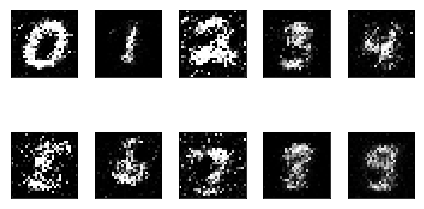

epoch = 2/100, d_loss=0.675, g_loss=0.819                                                                                                                                                                                                                           
epoch = 3/100, d_loss=0.685, g_loss=0.835                                                                                                                                                                                                                          
epoch = 4/100, d_loss=0.678, g_loss=0.839                                                                                                                      
epoch = 5/100, d_loss=0.683, g_loss=0.800                                                                                                                      
epoch = 6/100, d_loss=0.664, g_loss=0.836                                                                                                                      

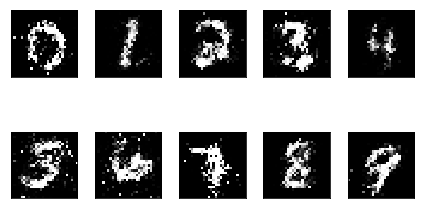

epoch = 12/100, d_loss=0.619, g_loss=0.887                                                                                                                      
epoch = 13/100, d_loss=0.633, g_loss=0.893                                                                                                                      
epoch = 14/100, d_loss=0.667, g_loss=0.879                                                                                                                      
epoch = 15/100, d_loss=0.663, g_loss=0.872                                                                                                                      
epoch = 16/100, d_loss=0.711, g_loss=0.921                                                                                                                                                                                                                           
epoch = 17/100, d_loss=0.643, g_loss=0.829                                                    

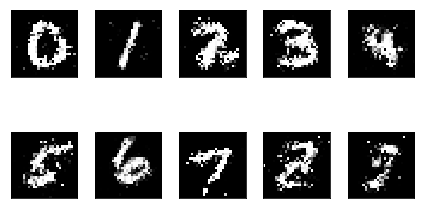

epoch = 22/100, d_loss=0.655, g_loss=0.880                                                                                                                      
epoch = 23/100, d_loss=0.672, g_loss=0.882                                                                                                                                                                                                                         
epoch = 24/100, d_loss=0.633, g_loss=0.896                                                                                                                      
epoch = 25/100, d_loss=0.659, g_loss=0.904                                                                                                                      
epoch = 26/100, d_loss=0.648, g_loss=0.861                                                                                                                      
epoch = 27/100, d_loss=0.653, g_loss=0.912                                                      

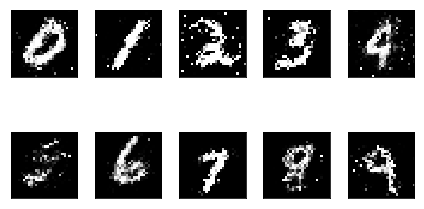

epoch = 32/100, d_loss=0.632, g_loss=0.891                                                                                                                      
epoch = 33/100, d_loss=0.662, g_loss=0.909                                                                                                                      
epoch = 34/100, d_loss=0.655, g_loss=0.925                                                                                                                      
epoch = 35/100, d_loss=0.643, g_loss=0.933                                                                                                                      
epoch = 36/100, d_loss=0.689, g_loss=0.887                                                                                                                      
epoch = 37/100, d_loss=0.666, g_loss=0.893                                                                                                                                                         

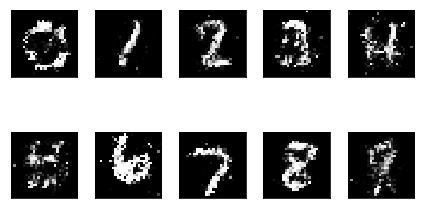

epoch = 42/100, d_loss=0.668, g_loss=0.937                                                                                                                      
epoch = 43/100, d_loss=0.620, g_loss=0.927                                                                                                                      
epoch = 44/100, d_loss=0.680, g_loss=0.902                                                                                                                      
epoch = 45/100, d_loss=0.657, g_loss=0.867                                                                                                                      
epoch = 46/100, d_loss=0.677, g_loss=0.888                                                                                                                      
epoch = 47/100, d_loss=0.598, g_loss=0.912                                                                                                                      
epoch = 48/100, d_loss=0.637, g_lo

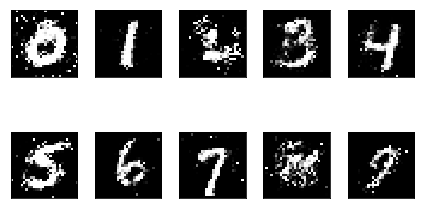

epoch = 52/100, d_loss=0.634, g_loss=0.928                                                                                                                                                                                                                                                                                                                                
epoch = 53/100, d_loss=0.638, g_loss=0.874                                                                                                                                                                                                                          
epoch = 54/100, d_loss=0.635, g_loss=0.862                                                                                                                      
epoch = 55/100, d_loss=0.642, g_loss=0.889                                                                                                                      
epoch = 56/100, d_loss=0.632, g_loss=0.940            

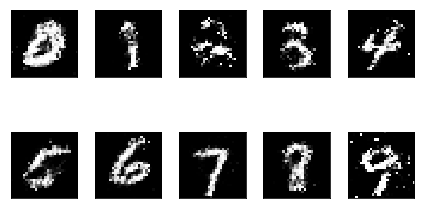

epoch = 62/100, d_loss=0.638, g_loss=0.868                                                                                                                      
epoch = 63/100, d_loss=0.618, g_loss=0.883                                                                                                                                                                                                                           
epoch = 64/100, d_loss=0.651, g_loss=0.893                                                                                                                      
epoch = 65/100, d_loss=0.664, g_loss=0.884                                                                                                                      
epoch = 66/100, d_loss=0.650, g_loss=0.889                                                                                                                      
epoch = 67/100, d_loss=0.630, g_loss=0.912                                                    

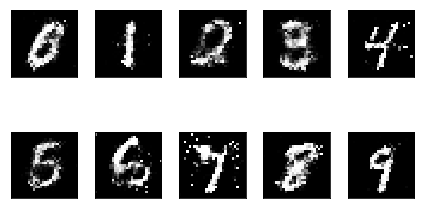

epoch = 72/100, d_loss=0.648, g_loss=0.878                                                                                                                      
epoch = 73/100, d_loss=0.640, g_loss=0.834                                                                                                                                                                                                                                                                                                                               
epoch = 74/100, d_loss=0.685, g_loss=0.887                                                                                                                      
epoch = 75/100, d_loss=0.648, g_loss=0.884                                                                                                                      
epoch = 76/100, d_loss=0.662, g_loss=0.899                                                                                                                 

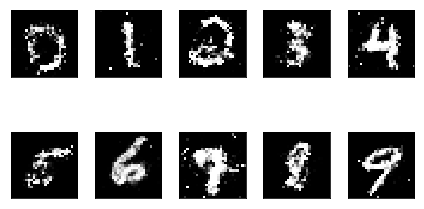

epoch = 82/100, d_loss=0.672, g_loss=0.914                                                                                                                      
epoch = 83/100, d_loss=0.675, g_loss=0.836                                                                                                                      
epoch = 84/100, d_loss=0.626, g_loss=0.908                                                                                                                                                                                                                          
epoch = 85/100, d_loss=0.659, g_loss=0.880                                                                                                                      
epoch = 86/100, d_loss=0.656, g_loss=0.916                                                                                                                                                                                                                      

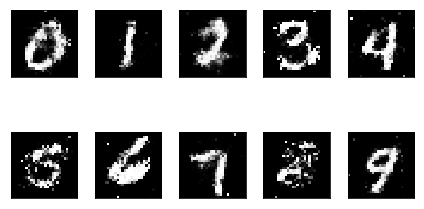

epoch = 92/100, d_loss=0.645, g_loss=0.867                                                                                                                      
epoch = 93/100, d_loss=0.643, g_loss=0.928                                                                                                                      
epoch = 94/100, d_loss=0.629, g_loss=0.889                                                                                                                      
epoch = 95/100, d_loss=0.657, g_loss=0.834                                                                                                                                                                                                                          
epoch = 96/100, d_loss=0.648, g_loss=0.892                                                                                                                                                                                                                      

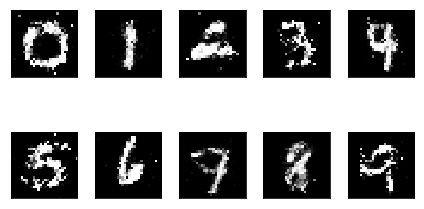

In [18]:
epochs = 100
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels],
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = np.arange(0, 10).reshape(-1, 1)
        
        x_fake = generator.predict([z, labels])

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

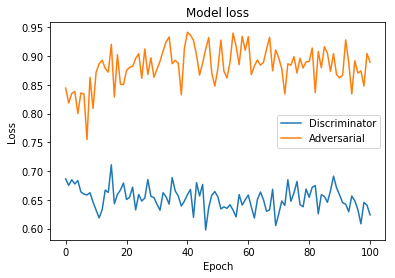

In [20]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

## References

* [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf)
* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
* [THE MNIST DATABASE of handwritten digits](http://yann.lecun.com/exdb/mnist/)
* [Keras-GAN](https://github.com/eriklindernoren/Keras-GAN)